$\newcommand{\x}[1]{\textbf{\textit{x}}_{#1}}$
$\newcommand{\alp}[1]{\alpha_{#1}}$
$\newcommand{\alphat}[1]{\bar{\alpha}_{#1}}$
$\newcommand{\sqrtalpha}[1]{\sqrt{\alpha_{#1}}}$
$\newcommand{\sqrtalphahat}[1]{\sqrt{\bar{\alpha}_{#1}}}$
$\newcommand{\xhat}[1]{\hat{\textbf{\textit{x}}}_{#1}}$
$\newcommand{\bmu}[1]{\mathbf{\mu}_{#1}}$
$\newcommand{\bSigma}[1]{\mathbf{\Sigma}_{#1}}$
$\newcommand{\argmin}[1]{\underset{#1}{\text{arg min}}}$

In [19]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import torch

from utils import MNIST, CIFAR10

train_set = MNIST()
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dimensions = train_set[0].shape
img_size = torch.prod(torch.tensor(dimensions))

## The data
First, let's have a look at our data. Our data will conist of images and will therefore have the dimensions (channels, height, width).<br>
These pictures are our "ground-truth", and we'll denote them as $\mathbf{\textit{x}}_0$. <br>
It is these pictures that we gradually will make more and more noisy in order to train our model.

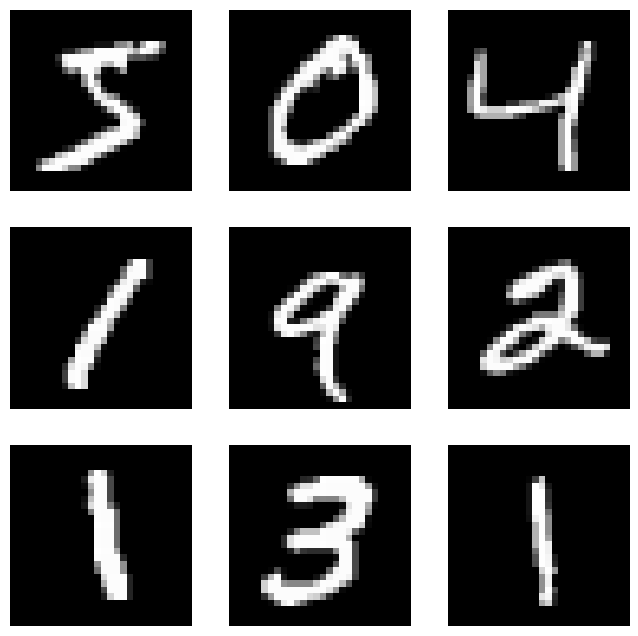

In [20]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a 
# grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set[i]
    img = img * 0.5 + 0.5
    axs[i//3, i%3].imshow(img.view(*dimensions).permute(1,2,0), cmap='gray')
    axs[i//3, i%3].axis('off')


## Noise schedule
The noise schedule is defined as: <br>
$\begin{equation}
q(\x{t}|\x{t-1}) = \mathcal{N}(\x{t};\sqrt{1-\beta_t}\x{t-1},\beta_t \mathbf{I})
\end{equation}$
Where $\beta_t$ are linear interpolations on the range from $\beta_{0}$ to $\beta_{T}$. Typically, the noise schedule will be in the range from $\beta_0=0.001$ to $\beta_T = 0.02$. <br>
#### The noise schedule describes what distribution each pixel value should follow in the next noisy image based on the prior slightly less noisy image.<br>
If we let $\alpha_t$ = $1-\beta_t$, it can be shown that some arbitrary timestep, $t$, will follow this distribution: <br>
$\begin{equation}
 q(\x{t}|\x{0}) = \mathcal{N}(\x{t}, \sqrt{\bar{\alpha}_t}\x{0}, (1-\bar{\alpha}_t) \mathbf{I})
\end{equation}$
Where $\bar{\alpha}_t = \prod_{t=1}^T \alpha_t$.<br>
The Markov-chain also assures us that it doesnt matter whether we condition of $\x{0}$ or $\x{t-1}$, since $\x{t-1}$ only depends on $\x{0}$ anyways. <br>
Using the reparameteriation trick, a sample can be drawn by calculating:
$\begin{equation}
\x{t} = \sqrtalphahat{t}\x{0} +\sqrt{1-\alphat{t}}\epsilon^* \hspace{10mm} \epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})
\end{equation}$
#### Using this fact, we can take some $\x{0}$, randomly sample some timesteps, $t \in [1, T]$, find the pertaining distributions for the noisy images and draw a sample from this distribution:

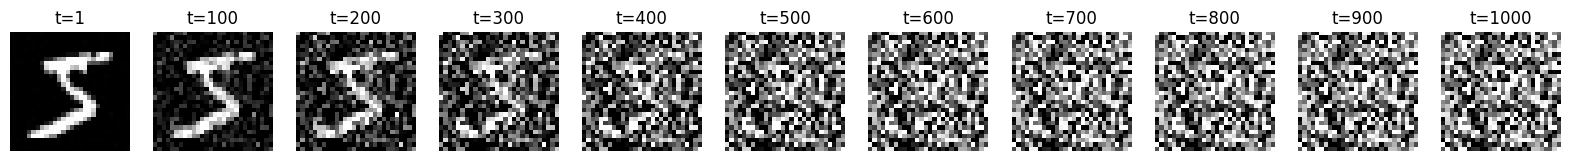

In [21]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 1000
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.savefig("figures/noisy_images.png", dpi=300, bbox_inches='tight')
plt.show()


# Examining the distribution

A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel. <br>
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. <br>
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

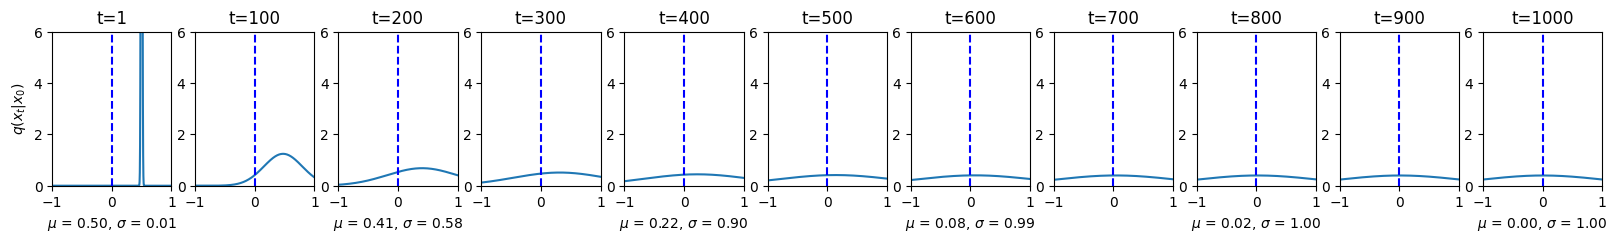

In [22]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('$q(x_t | x_0)$')

plt.savefig("figures/pixel_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# The distribution of $p(\x{T})$
To show that the distribution of the final layer ($p(\x{T})$) actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

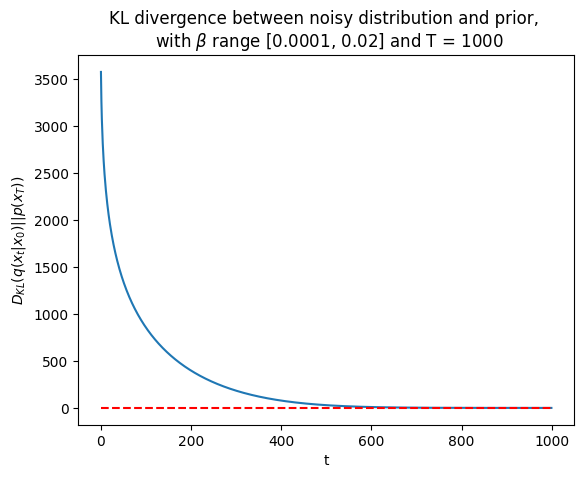

In [23]:
from tqdm import tqdm

## this small image is just a 10x10 patch of the original image

KL_list = np.zeros(T)
for t in range(T):
    mu = noise_schedule.sqrt_alpha_hat[t] * x0.flatten()
    std = noise_schedule.sqrt_one_minus_alpha_hat[t]

    k1 = img_size * std ** 2
    k2 = torch.sum(mu ** 2)
    k3 = - 2 * img_size * torch.log(std)
    kl = 1/2 * (k1 + k2 + k3 - img_size)
    
    KL_list[t] = kl.detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("$D_{KL}(q(x_t | x_0) || p(x_T))$")
plt.hlines(0, 0, T, color='r', linestyle='--')
plt.show()


## Encoding the timesteps
It can be shown, that in order to train a diffusion model, the following loss function can be used:
$\begin{equation}
\mathcal{L}_{simple} = ||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2
\end{equation}$
Where $\epsilon^*$ is the noise used to sample $\x{t}$ from $\x{0}$, and where $\hat{\epsilon}_{\theta}$ is our models best guess at this noise. <br>
Since we're making one model for all timesteps, it could be beneficial to somehow tell the model which timestep it is in (notice that $t$ is also an input to the model). There are different approaches to this: deterministic timeembeddings and learnable timeembeddings. <br>
We decided to go with deterministic, sinusoidal encoding. This means that every $t$ gets mapped to a unique $sin$ and $cos$ wave as visualized below using a heat map:

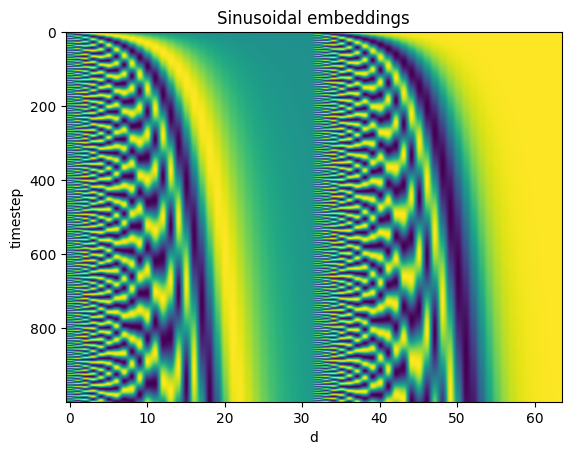

In [24]:
from utils import SinusoidalEmbeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings, cmap='viridis', aspect='auto')
plt.ylabel("timestep")
plt.xlabel("d")
plt.title("Sinusoidal embeddings")
plt.savefig("figures/sinusoidal_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()


## The model
The model is a simple residual UNet using convolutions. <br>
The simple loss, $\mathcal{L}_{simple}$, can be summarised as:
   
1. **Repeat until convergence:**
   - $\x{0} \sim q(\x{0})$
   - $t \sim \text{Uniform}(1,\dots,T)$
   - $\epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})$
   - $\x{t} \gets \sqrtalphahat{t}\x{0} + \sqrt{1-\alphat{t}}\epsilon^*$
   - Take a gradient descent step on $\nabla_{\theta}||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2$

The loss function can be found inside the model class.

In [47]:
from utils import SimpleModel, ResNET
import torch.nn as nn
mse = nn.MSELoss()

network_args = [dimensions[0], 64, [64, 128, 256, 512]]
simple_network = ResNET(*network_args)
model_args = [simple_network, noise_schedule, dimensions, device]
simple_model = SimpleModel(*model_args)
simple_model.load_model()
num_params = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)
print("Number of parameters: ", num_params)

Failed to load model from ../models/simple_model.pt
Initializing new model
Number of parameters:  12517057


## Visualizing performance
It could be a good idea to see how well our model is performing after each epoch. Of course, we'll look at the loss, but we'll also take a look at how well the model can sample new images.
The sample process can be described as:
1. **Initialize:**
   - $\x{T} \sim \mathcal{N}(\mathbf{0},\mathbf{1})$ 

2. **For $t$ from $T$ down to $1$ do the following:**
   - $\x{t-1} \gets \frac{1}{\sqrtalpha{t}}\x{t}-\frac{1-\alp{t}}{\sqrt{1-\alphat{t}}\sqrtalpha{t}}\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)$
   
   - **If $t > 0$:**
     - $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{1})$
     - $\x{t-1} \gets \x{t-1} + \mathbf{z}\sigma_q(t)$

3. **Return:**
   - $x_0$

The code for finding the prior sample (finding $\x{t-1}$ from $\x{t}$) can be found in the model class.



In [29]:
from IPython.display import clear_output

def sample_and_show_image(model, title="Sampled image"):
    xt = model.sample()
    xt = (xt - xt.min()) / (xt.max() - xt.min())
    img = xt.view(*dimensions).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def show_losses(losses, title="Losses"):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.xticks(np.arange(0, len(losses)))
    plt.show()

In [30]:
def training_loop(model, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    epoch_loss = np.zeros(epochs)

    num_paramters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters = np.zeros((epochs, num_paramters))

    for epoch in range(epochs):
        losses = torch.zeros(len(train_loader))

        for i, x0 in enumerate(tqdm(train_loader)):
            loss = model.loss(x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i] = loss.item()

        clear_output(wait=True)
        print(f"Epoch: {epoch}")
        print(losses.mean().item())
        model.save_model()
        epoch_loss[epoch] = losses.mean().item()

        model.eval()
        sample_and_show_image(model, "Epoch {}".format(epoch))
        model.train()
        
        show_losses(epoch_loss[:epoch + 1], "Epoch {}".format(epoch))

        curr_params = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters() if p.requires_grad])
        parameters[epoch] = curr_params
    
    return epoch_loss, parameters

Epoch: 2
0.039477601647377014
Model saved to ../models/simple_model.pt
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 38.20it/s]


Done sampling image


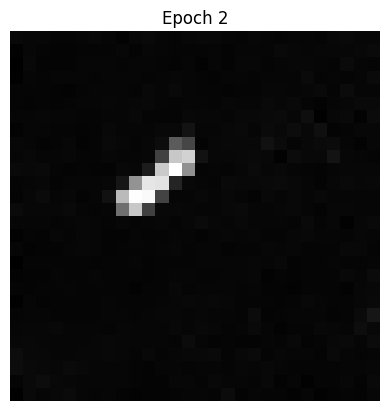

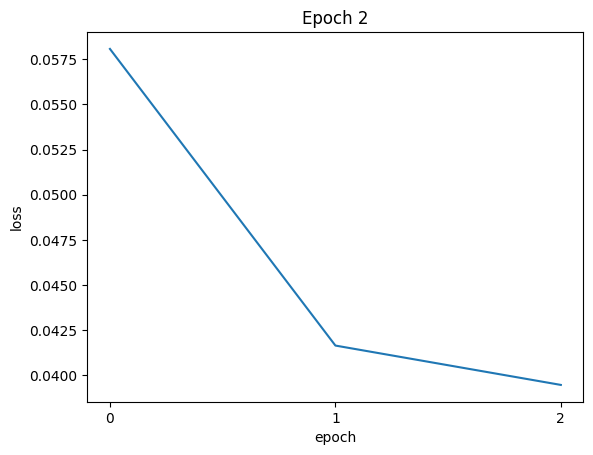

  8%|▊         | 78/937 [02:04<22:49,  1.59s/it] 


KeyboardInterrupt: 

In [31]:
simple_model_losses, simple_model_parameters = training_loop(simple_model, 30)
np.save("../data/simple_model_losses.npy", simple_model_losses)
np.save("../data/simple_model_parameters.npy", simple_model_parameters)

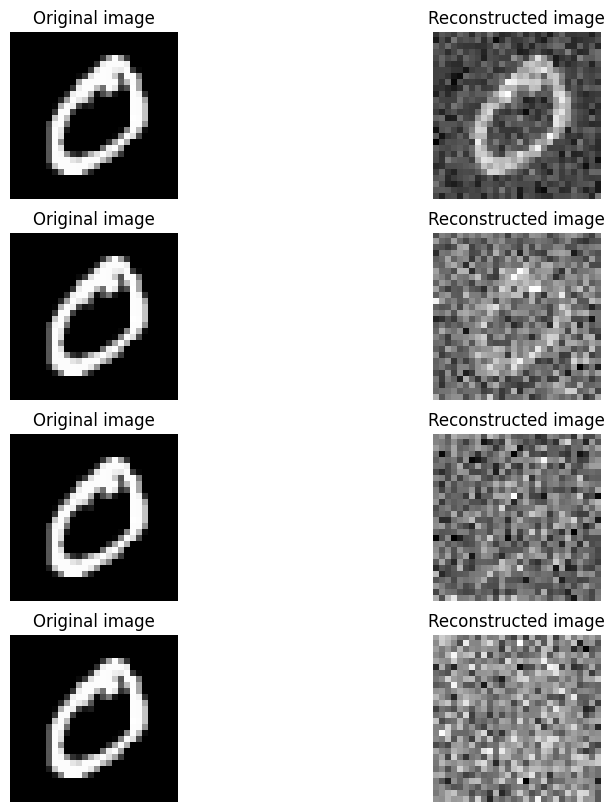

In [58]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
x0 = train_set[1]
ts = [100, 300, 500, 800]
for i, t in enumerate(ts):
    xt, _, _ = noise_schedule.make_noisy_images(x0, torch.tensor(t).view(-1, 1))
    xt = xt.view(1, *dimensions).to(device)
    embedding = embeddings[t].view(1,-1).to(device)
    eps_guess = simple_model.network(xt, embedding).detach().cpu()
    xt = xt.detach().cpu()
    x0_guess = (xt - noise_schedule.sqrt_one_minus_alpha_hat[t] * eps_guess) / noise_schedule.sqrt_alpha_hat[t]
    x0_guess = (x0_guess - x0_guess.min()) / (x0_guess.max() - x0_guess.min())
    reconstructed_img = x0_guess.view(*dimensions).permute(1, 2, 0).numpy()
    original_img = x0.view(*dimensions).permute(1, 2, 0).numpy()
    axs[i, 0].imshow(original_img, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original image")
    axs[i, 1].imshow(reconstructed_img, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Reconstructed image")
    axs[i, 1].set_ylabel(f"t = {t}")

plt.savefig("figures/reconstructed_images.png", dpi=300, bbox_inches='tight')
plt.show()



## Another type of model
We will repeat the above, but for another type of loss function. 
This loss function doesnt predict the noise, $\epsilon^*$, but rather the original image, $\x{0}$. <br>
We wont go into too many details around how this model works, but we'll later try to compare the performance of the different models.

In [48]:
from utils import MuModel

torch.cuda.empty_cache()

mu_network = ResNET(*network_args)
model_args = [mu_network, noise_schedule, dimensions, device]
mu_model = MuModel(*model_args)
mu_model.load_model()

Failed to load model from ../models/mu_model.pt
Initializing new model


Epoch: 1
0.1608923226594925
Model saved to ../models/mu_model.pt
Sampling image..


100%|██████████| 999/999 [00:09<00:00, 106.96it/s]


Done sampling image


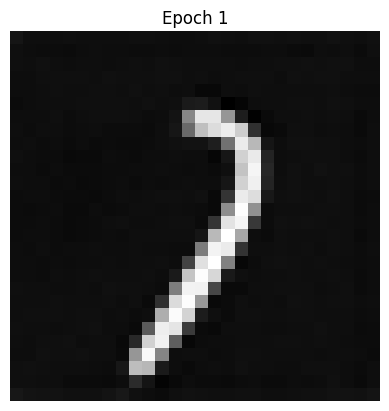

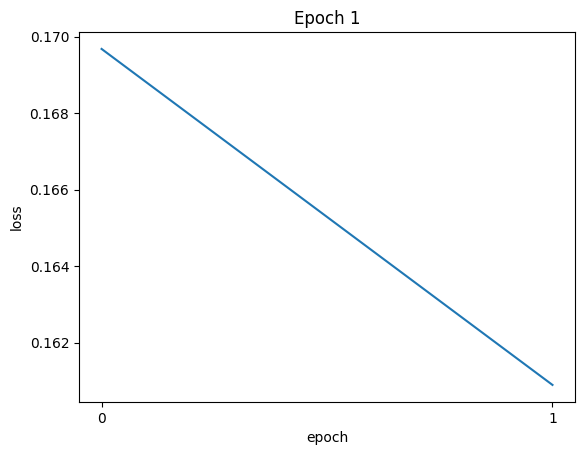

  0%|          | 4/937 [00:08<31:26,  2.02s/it]  


KeyboardInterrupt: 

In [49]:
mu_model_losses, mu_model_parameters = training_loop(mu_model, 20)
np.save("../data/mu_model_losses.npy", mu_model_losses)
np.save("../data/mu_model_parameters.npy", mu_model_parameters)

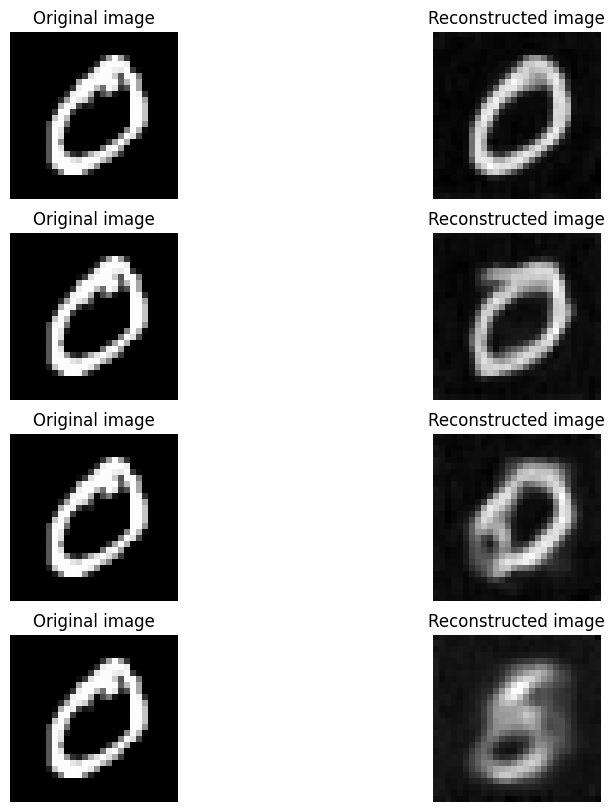

In [59]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
x0 = train_set[1]
ts = [100, 300, 500, 800]
for i, t in enumerate(ts):
    xt, _, _ = noise_schedule.make_noisy_images(x0, torch.tensor(t).view(-1, 1))
    xt = xt.view(1, *dimensions).to(device)
    embedding = embeddings[t].view(1,-1).to(device)
    x0_guess = mu_model.network(xt, embedding).detach().cpu()
    reconstructed_img = x0_guess.view(*dimensions).permute(1, 2, 0).numpy()
    original_img = x0.view(*dimensions).permute(1, 2, 0).numpy()
    axs[i, 0].imshow(original_img, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original image")
    axs[i, 1].imshow(reconstructed_img, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Reconstructed image")
    axs[i, 1].set_ylabel(f"t = {t}")

plt.savefig("figures/reconstructed_images.png", dpi=300, bbox_inches='tight')
plt.show()



In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=1)

simple_model_parameters = np.load("../data/simple_model_parameters.npy")
simple_model_losses = np.load("../data/simple_model_losses.npy")
simple_model_parameters = scaler.fit_transform(simple_model_parameters)
simple_model_paramters_pca = pca.fit_transform(simple_model_parameters)
best_params_pca = simple_model_paramters_pca[np.argmin(simple_model_losses)]

In [47]:
def make_state_dict_from_paramters(model, parameters):
    state_dict = model.state_dict()
    start = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            end = start + param.numel()
            state_dict[name] = parameters[start:end].view(param.shape).to(device)
            start = end
    return state_dict

300it [00:43,  6.83it/s]


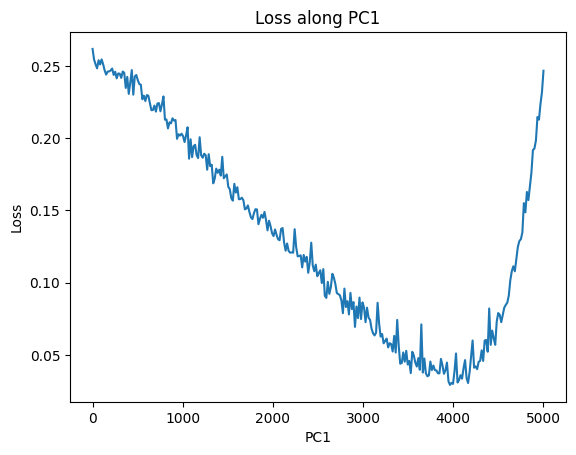

In [65]:
params_pca_std = np.std(simple_model_paramters_pca)
start_params = 0
end_params = 5000
resolution = 300

xx = np.linspace(start_params, end_params, resolution)
yy = np.zeros_like(xx)

simple_model.eval()

for i, x in tqdm(enumerate(xx)):
    params = pca.inverse_transform(x.reshape(1,-1))
    params = scaler.inverse_transform(params)[0]
    state_dict = make_state_dict_from_paramters(simple_model, torch.tensor(params).float())
    simple_model.load_state_dict(state_dict)
    x0 = train_set[:64]
    l = simple_model.loss(x0).item()
    yy[i] = l

plt.plot(xx, yy)
plt.xlabel("PC1")
plt.ylabel("Loss")
plt.title("Loss along PC1")
plt.show()


In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=2)

simple_model_parameters = np.load("../data/simple_model_parameters.npy")
simple_model_losses = np.load("../data/simple_model_losses.npy")
simple_model_parameters = scaler.fit_transform(simple_model_parameters)
simple_model_paramaters_pca = pca.fit_transform(simple_model_parameters)
best_params_pca = simple_model_paramaters_pca[np.argmin(simple_model_losses)]
params_pca_std = np.std(simple_model_paramaters_pca, axis=0)

In [142]:
start_params = 0
end_params = 3000
resolution = 20

xx = np.linspace(start_params, end_params, resolution)
yy = np.linspace(start_params, end_params, resolution)
xx, yy = np.meshgrid(xx, yy)
zz = np.zeros_like(xx)

simple_model.eval()

for i in tqdm(range(resolution)):
    for j in range(resolution):
        params = pca.inverse_transform(np.array([xx[i,j], yy[i,j]]).reshape(1,-1))
        params = scaler.inverse_transform(params)[0]
        state_dict = make_state_dict_from_paramters(simple_model, torch.tensor(params).float())
        simple_model.load_state_dict(state_dict)
        x0 = train_set[:64]
        l = simple_model.loss(x0).item()
        zz[i,j] = l



100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


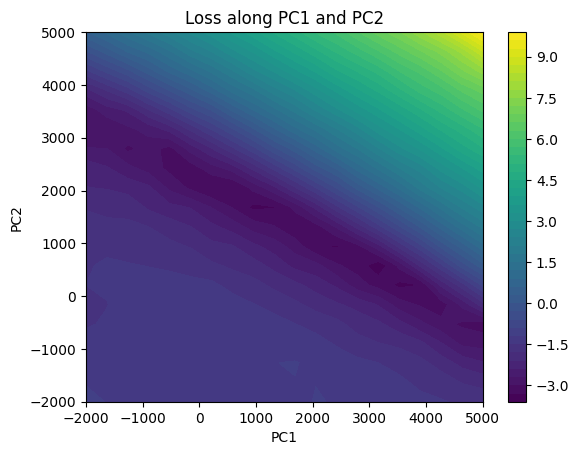

In [143]:
## make contour plot

plt.contourf(xx, yy, np.log(zz), levels=50, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loss along PC1 and PC2")
plt.colorbar()
plt.savefig("figures/loss_contour.png", dpi=300, bbox_inches='tight')

plt.show()

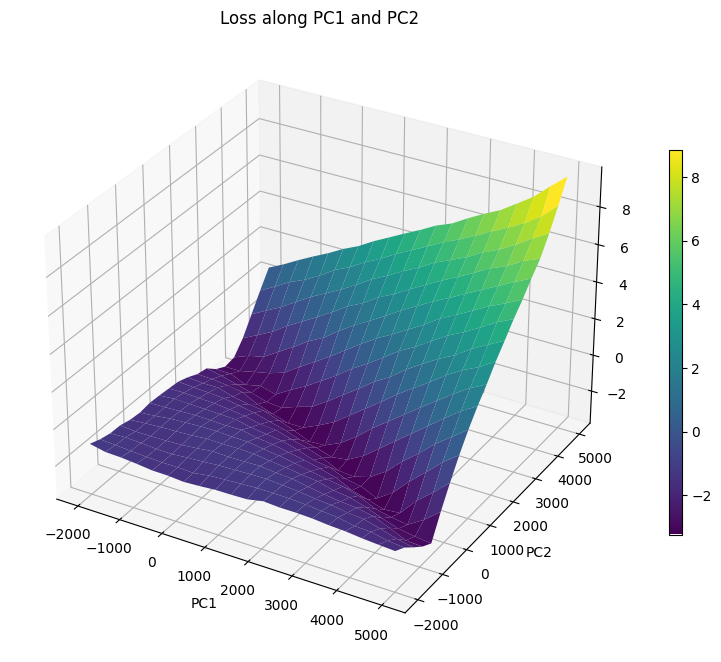

In [144]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, np.log(zz),cmap='viridis', edgecolor='none')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Loss along PC1 and PC2")
plt.savefig("figures/loss_surface.png", dpi=300, bbox_inches='tight')
fig.colorbar(surf, shrink=0.5, aspect=30)
plt.show()

